In [302]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score
#clf = svm.SVC(kernel='linear', C=1)


from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc, font_manager
rc('font',family="NanumSquareR")
from datetime import datetime
import featuretools as ft
from datetime import datetime
import os
from sklearn.ensemble import RandomForestClassifier
from ggplot import *
from sklearn.linear_model import LinearRegression
import scipy.stats as st
#-*- coding: utf-8 -*-

In [303]:
os.chdir("C:\\Users\\kmlam\\Documents\\work\\competition1")
train=pd.read_csv("train.csv",engine="python")
test =pd.read_csv("test.csv",engine="python")
subways=pd.read_csv("Subways.csv",engine="python")
school=pd.read_csv("Schools.csv",engine="python")

In [304]:
train.head()

,key,apartment_id,city,transaction_year_month,transaction_date,year_of_completion,exclusive_use_area,floor,latitude,longitude,...,lowest_building_in_sites,heat_type,heat_fuel,room_id,supply_area,total_household_count_of_area_type,room_count,bathroom_count,front_door_structure,transaction_real_price
0,0,5584,1,200601,11~20,1999,47.43,6,37.585965,127.000231,...,4.0,individual,gas,91120,65.63,46,1.0,1.0,corridor,215000000
1,1,5584,1,200601,11~20,1999,44.37,8,37.585965,127.000231,...,4.0,individual,gas,91119,61.39,10,2.0,1.0,corridor,200000000
2,2,5059,1,200601,11~20,1992,54.70,8,37.580511,127.014016,...,9.0,individual,gas,8430,72.36,201,2.0,1.0,corridor,168000000
3,3,2816,1,200601,11~20,1993,64.66,11,37.580324,127.011788,...,11.0,individual,gas,5839,87.30,284,2.0,1.0,corridor,165000000
4,4,2816,1,200601,11~20,1993,106.62,7,37.580324,127.011788,...,11.0,individual,gas,5836,127.74,112,4.0,2.0,stairway,280000000


In [305]:
train['trans_year'] = train['transaction_year_month'].apply(lambda x: str(x)[:4]).astype(int)
test['trans_year'] = test['transaction_year_month'].apply(lambda x: str(x)[:4]).astype(int)
train['transaction_daydiff']=(pd.to_datetime('2019-01-01')-pd.to_datetime(train['transaction_year_month'].astype('str').str.slice(0,4)+"-"+train['transaction_year_month'].astype('str').str.slice(4,6)+"-01")).dt.days
test['transaction_daydiff']=(pd.to_datetime('2019-01-01')-pd.to_datetime(test['transaction_year_month'].astype('str').str.slice(0,4)+"-"+test['transaction_year_month'].astype('str').str.slice(4,6)+"-01")).dt.days

In [309]:
def get_specific_mean(var_names,train,test,chunk_var=[],bins_num=[]):
    train['index']=1
    test['index']=0
    data=pd.concat([train,test],axis=0)
    if(len(chunk_var)!=0):
        for i,j in zip(chunk_var,bins_num):
            data[i+"chunk"]=pd.cut(data[i],bins=j)
    
    var_names.extend([x+"chunk" for x in chunk_var])
    train=data.loc[data['index']==1,]
    test=data.loc[data['index']==0,]
    apartment_id_count=train.groupby(var_names)['transaction_real_price'].std().reset_index(name="_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'std')
    apartment_id_count=pd.merge(apartment_id_count,train.groupby(var_names).size().reset_index(name="_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'count'),on=var_names,how='left')
    apartment_id_count=pd.merge(apartment_id_count,train.groupby(var_names)['transaction_real_price'].mean().reset_index(name="_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'mean'),on=var_names,how='left')
    apartment_id_count=pd.merge(apartment_id_count,train.groupby(var_names)['transaction_daydiff'].std().reset_index(name="_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'daydiff std'),on=var_names,how='left')
    
    train=pd.merge(train,apartment_id_count,on=var_names,how='left')
    train=train.drop([x+"chunk" for x in chunk_var],axis=1)
    train=train.drop(['index'],axis=1)
    
    train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'mean']=np.where(train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'count']==1,np.nan,(train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'mean']*train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'count']-train['transaction_real_price'])/(train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'count']-1))
    #train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'daydiff mean']=np.where(train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'count']==1,np.nan,(train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'daydiff mean']*train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'count']-train['transaction_daydiff'])/(train["_".join(var_names)+" "+"-".join([str(x) for x in bins_num])+" "+'count']-1))
    
    test=pd.merge(test,apartment_id_count,on=var_names,how='left')
    test=test.drop([x+"chunk" for x in chunk_var],axis=1)
    test=test.drop(['index'],axis=1)

    return train,test

In [310]:
train['trans_year'].describe()

count    1.601458e+06
mean     2.012351e+03
std      3.778057e+00
min      2.006000e+03
25%      2.009000e+03
50%      2.013000e+03
75%      2.016000e+03
max      2.018000e+03
Name: trans_year, dtype: float64

In [311]:
train,test=get_specific_mean(var_names=['apartment_id','exclusive_use_area'],chunk_var=['floor'],bins_num=[50],train=train,test=test)
print(1)
train,test=get_specific_mean(var_names=['apartment_id','exclusive_use_area','floor'],train=train,test=test)
print(1)
train,test=get_specific_mean(var_names=['apartment_id','exclusive_use_area','floor','trans_year'],train=train,test=test)
print(1)
train,test=get_specific_mean(var_names=['apartment_id','exclusive_use_area'],chunk_var=['floor','trans_year'],bins_num=[50,6],train=train,test=test)
print(1)
train,test=get_specific_mean(var_names=['apartment_id','exclusive_use_area','trans_year'],chunk_var=['floor'],bins_num=[50],train=train,test=test)
print(1)
train['MB_GH_JI']=np.where((train['trans_year']>=2006) & (train['trans_year']<=2007),'MH',np.where((train['trans_year']<=2012),'MB',np.where((train['trans_year']<=2016),"GH","JI")))
test['MB_GH_JI']=np.where((test['trans_year']>=2006) & (test['trans_year']<=2007),'MH',np.where((test['trans_year']<=2012),'MB',np.where((test['trans_year']<=2016),"GH","JI")))

1
1
1
1
1


In [320]:
len(test.columns)
train['MB']

103

In [314]:
train.corr()['transaction_real_price']

key                                                                            0.296135
apartment_id                                                                   0.160393
city                                                                           0.399349
transaction_year_month                                                         0.285657
year_of_completion                                                             0.132442
exclusive_use_area                                                             0.518922
floor                                                                          0.129241
latitude                                                                       0.386292
longitude                                                                     -0.389087
address_by_law                                                                -0.394201
total_parking_capacity_in_site                                                 0.310130
total_household_count_in_sites  

In [315]:
train=train.reset_index(drop=True)

train=train.drop(['apartment_id','transaction_date','room_id'],axis=1)
test=test.drop(['apartment_id','transaction_date','room_id'],axis=1)

train['park_cap_ratio']=train['total_parking_capacity_in_site']/train['total_household_count_in_sites']
test['park_cap_ratio']=test['total_parking_capacity_in_site']/test['total_household_count_in_sites']

train['cur_floor_rate1']=train['floor']/train['tallest_building_in_sites']
train['cur_floor_rate2']=train['floor']/train['lowest_building_in_sites']
train['floor_density']=train['apartment_building_count_in_sites']/(train['tallest_building_in_sites']-train['lowest_building_in_sites']+1)

train['trans_year'] = train['transaction_year_month'].apply(lambda x: str(x)[:4]).astype(int)
train['trans_month'] = train['transaction_year_month'].apply(lambda x: str(x)[4:]).astype(int)

test['trans_year'] = test['transaction_year_month'].apply(lambda x: str(x)[:4]).astype(int)
test['trans_month'] = test['transaction_year_month'].apply(lambda x: str(x)[4:]).astype(int)

train['gap_bet_transYear_compleYear'] = train['trans_year'] - train['year_of_completion']
test['gap_bet_transYear_compleYear'] = test['trans_year'] - test['year_of_completion']

train['age_of_apartment'] = 2019 - train['year_of_completion']
test['age_of_apartment'] = 2019 - test['year_of_completion']

train['my_index_1'] = (2019 - train['trans_year']) / train['age_of_apartment']
test['my_index_1'] = (2019 - test['trans_year']) / test['age_of_apartment']

train['my_index_2'] = train['my_index_1'] / train['tallest_building_in_sites']
test['my_index_2'] = test['my_index_1'] / test['tallest_building_in_sites']

train=train.drop(['trans_year','age_of_apartment','transaction_year_month'],axis=1)
test=test.drop(['trans_year','age_of_apartment','transaction_year_month'],axis=1)

train['total_household_per_building_count'] = train['total_household_count_in_sites'] / train['apartment_building_count_in_sites']
test['total_household_per_building_count'] = test['total_household_count_in_sites'] / test['apartment_building_count_in_sites']

test['cur_floor_rate1']=test['floor']/test['tallest_building_in_sites']
test['cur_floor_rate2']=test['floor']/test['lowest_building_in_sites']
test['floor_density']=test['apartment_building_count_in_sites']/(test['tallest_building_in_sites']-test['lowest_building_in_sites']+1)

train['household_ratio']=train['total_household_count_of_area_type']/train['total_household_count_in_sites']
test['household_ratio']=test['total_household_count_of_area_type']/test['total_household_count_in_sites']

train['bathroom_count_per_area'] = train['bathroom_count'] / train['supply_area']
test['bathroom_count_per_area'] = test['bathroom_count'] / test['supply_area']

train['room_count_per_area'] = train['room_count'] / train['supply_area']
test['room_count_per_area'] = test['room_count'] / test['supply_area']

train['total_room'] = train['room_count'] + train['bathroom_count']
test['total_room'] = test['room_count'] + test['bathroom_count']

train['total_room_per_area'] = train['total_room'] / train['supply_area']
test['total_room_per_area'] = test['total_room'] / test['supply_area']

train['room_count_per_exclusive_area'] = train['room_count'] / train['exclusive_use_area']
test['room_count_per_exclusive_area'] = test['room_count'] / test['exclusive_use_area']

train['bathroom_per_exclusive_area'] = train['bathroom_count'] / train['exclusive_use_area']
test['bathroom_per_exclusive_area'] = test['bathroom_count'] / test['exclusive_use_area']

train['total_room_per_exclusive_area'] = train['total_room'] / train['exclusive_use_area']
test['total_room_per_exclusive_area'] = test['total_room'] / test['exclusive_use_area']

train['living_area'] = train['supply_area'] - train['exclusive_use_area']
test['living_area'] = test['supply_area'] - test['exclusive_use_area']

train['bathroom_per_living_area'] = train['bathroom_count'] / train['living_area']
test['bathroom_per_living_area'] = test['bathroom_count'] / test['living_area']

In [316]:
school['foundation_date']=school['foundation_date'].astype('str').str.slice(0,4)
school=school.drop(['school_code','latitude','longitude'],axis=1)
subways['subway_num']=subways.apply(lambda x: x['subway_line'].count(','),axis=1)+1

for i in ['1','2','3','4','5','6','7','8','9','KJ','US','AP','KC','DL','ND']:
    subways['subway_'+i]=subways.apply(lambda x: x['subway_line'].count(i),axis=1)
    
subways=subways.drop(['subway_line','latitude','longitude','station_id'],axis=1)

s1=subways.groupby(['address_by_law']).agg(['sum']).reset_index()
s1.columns = ['_'.join(col).strip() for col in s1.columns.values]
s1.rename(columns={'address_by_law_':'address_by_law' }, inplace=True)
s2=subways.groupby(['address_by_law']).size().reset_index(name='subways_count')
subways=pd.merge(s1,s2,on='address_by_law',how='left')

train=pd.merge(train,subways,on='address_by_law',how='left')
test=pd.merge(test,subways,on='address_by_law',how='left')

school['foundation_date']=school['foundation_date'].astype('int')
school=pd.get_dummies(school)

agg_funs={
    'foundation_date':['mean','min','max'],
    'school_class_elementary':['sum'],
    'school_class_high':['sum'],
    'school_class_middle':['sum'],
    'operation_type_national':['sum'],
    'operation_type_private':['sum'],
    'operation_type_public':['sum'],
    'highschool_type_autonomous':['sum'],
    'highschool_type_general':['sum'],
    'highschool_type_objective':['sum'],
    'highschool_type_specialized':['sum'],
    'gender_both':['sum'],
    'gender_female':['sum'],
    'gender_male':['sum']
}

school=school.groupby(['address_by_law']).agg(agg_funs).reset_index(drop=False)
school.columns = ['_'.join(col).strip() for col in school.columns.values]

school.rename(columns={'address_by_law_':'address_by_law' }, inplace=True)

train=pd.merge(train,school,on='address_by_law',how='left')
test=pd.merge(test,school,on='address_by_law',how='left')

train=train.drop(['address_by_law'],axis=1)
test=test.drop(['address_by_law'],axis=1)

In [322]:
#train.to_csv("train1.csv")
#test.to_csv("test1.csv")
#train.dtypes
#test.columns

In [323]:
train=pd.get_dummies(train)
test=pd.get_dummies(test)
test['MB_GH_JI_MH']=0

input_var=[x for x in train.columns if x not in ['transaction_real_price','key']]#,'heat_type','heat_fuel','front_door_structure']]
#categorical_feats = ['heat_type','heat_fuel','front_door_structure']
X=train[input_var]
y=train['transaction_real_price']

X_test=test[input_var]
#y_test=test['transaction_real_price']

In [324]:
len(train)

1601458

In [325]:
import lightgbm as lgb
param = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.2,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X))
predictions = np.zeros(len(X_test))
#start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("fold n°{}".format(fold_))
    X1=X.iloc[trn_idx].copy()
    y1=y.iloc[trn_idx].copy()
    X2=X.iloc[val_idx].copy()
    y2=y.iloc[val_idx].copy()
    
    #X1['mean']=np.where(X1['count']==1,np.nan,(X1['mean']*X1['count']-X1['transaction_real_price'])/(X1['count']-1))
    #X2['mean']=np.where(X2['count']==1,np.nan,(X2['mean']*X2['count']-X2['transaction_real_price'])/(X2['count']-1))
     
    trn_data = lgb.Dataset(X1, label=y1)#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(X2, label=y2)#, categorical_feature=categorical_feats)
        
    num_round = 15000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, y)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.92837e+07	valid_1's rmse: 4.08382e+07
[200]	training's rmse: 3.47729e+07	valid_1's rmse: 3.75358e+07


KeyboardInterrupt: 

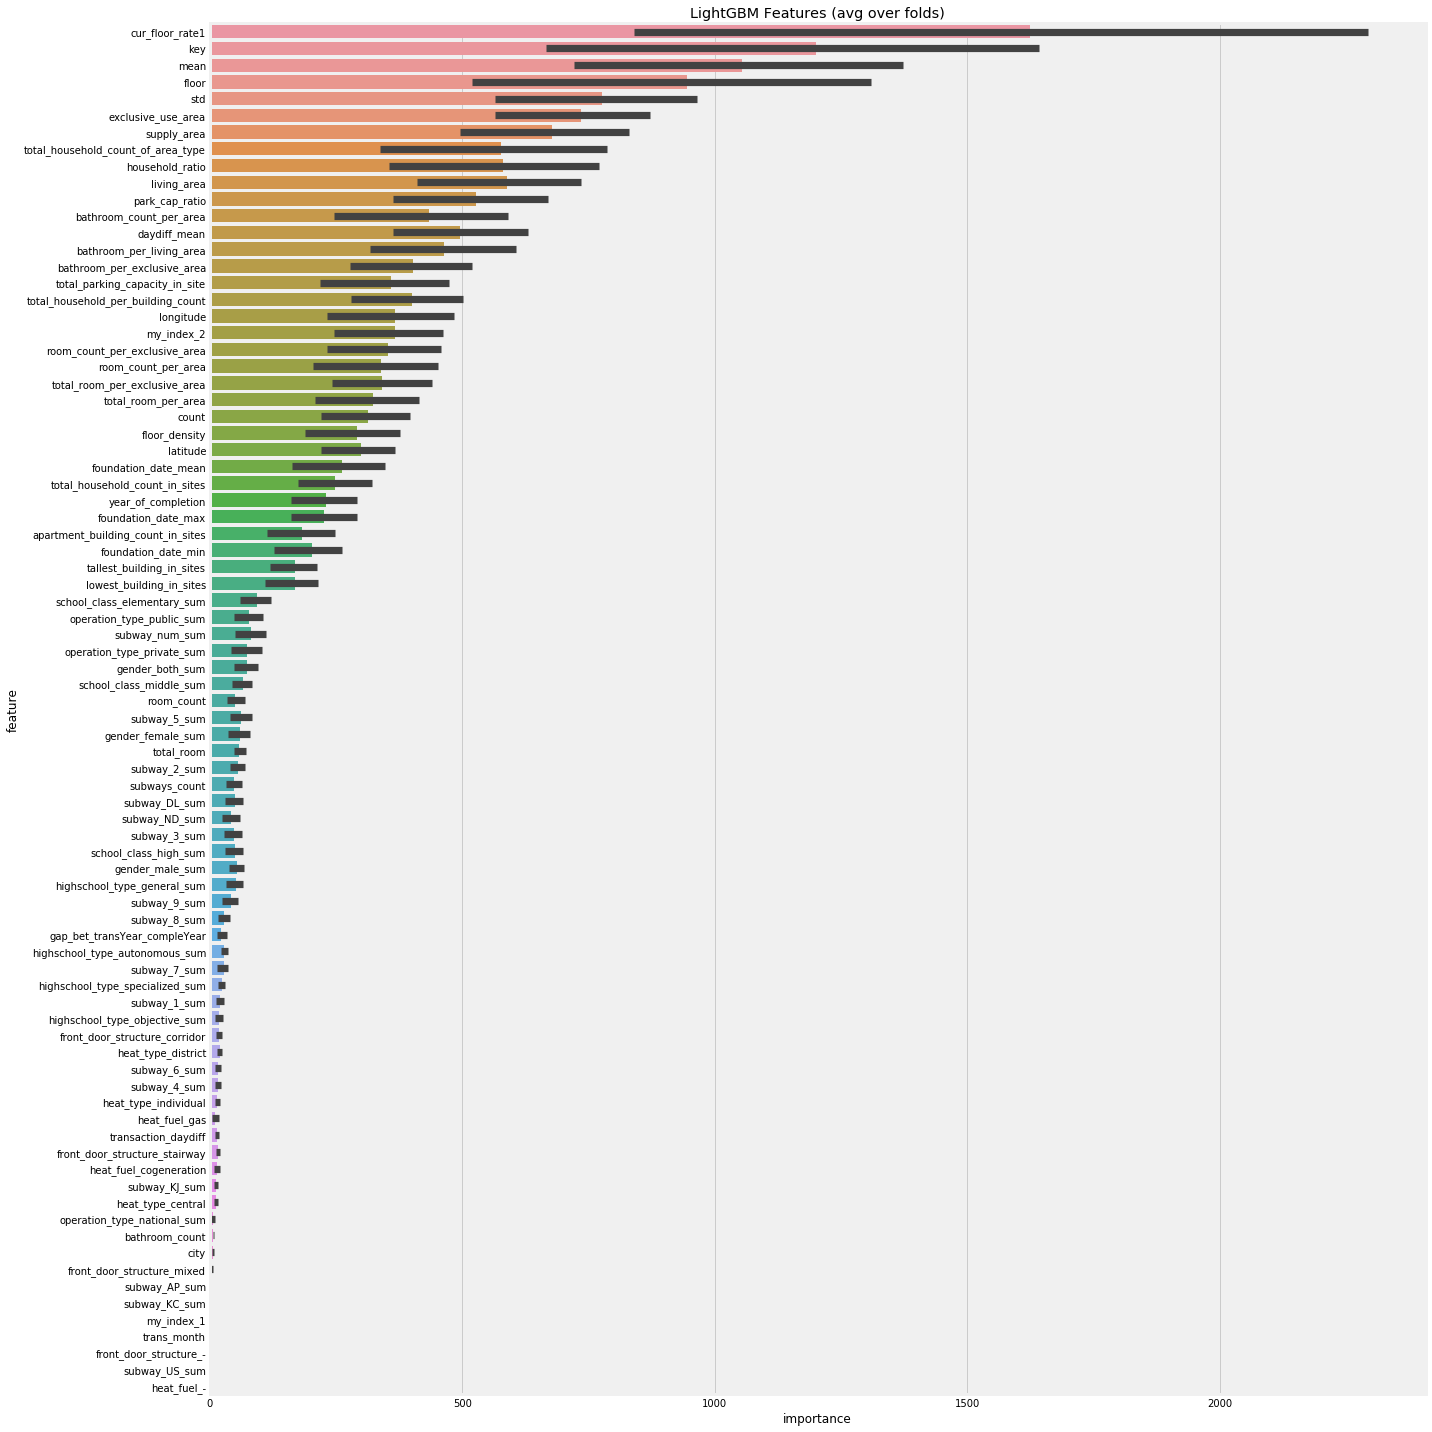

In [44]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(20,20))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_YH_GI_importances1.png')

In [ ]:
sub=pd.read_csv("submission.csv",engine='python')
sub['transaction_real_price']=predictions
sub.to_csv("submission_lgbm_GI_YH.csv",index=False)

In [35]:
(2.96058e+07+3.00206e+07+2.9708e+07+3.0015e+07+3.08769e+07)/5

30045260.0

In [74]:
from catboost import Pool
from catboost import CatBoostRegressor
cbm0 = CatBoostRegressor(rsm=0.8, depth=2,iterations=1000, learning_rate=0.1,eval_metric='RMSE')


In [83]:
#train.fillna(0,inplace=True)
#test.fillna(0,inplace=True)

X=X.iloc[1:2000]
y=y.iloc[1:2000]
#X_test=X.iloc[200001:202000]
#y_test=y.iloc[200001:202000]

In [89]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X))
predictions = np.zeros(len(X_test))
#start = time.time()
feature_importance_df = pd.DataFrame()
cbm0 = CatBoostRegressor(rsm=0.8, depth=2,iterations=10, learning_rate=0.1,eval_metric='RMSE')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("fold n°{}".format(fold_))
    
    cbm0.fit(X.iloc[trn_idx],y.iloc[trn_idx],plot=True,eval_set=(X.iloc[val_idx],y.iloc[val_idx]),cat_features=cate_features_index)
    cbm0.get_best_iteration()
    oof[val_idx] = cbm0.predict(X.iloc[val_idx])
    
    #model.predict(test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X.columns
    fold_importance_df["importance"] = cbm0.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += cbm0.predict(X_test) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, y)**0.5))


fold n°0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 477201450.5403661	test: 476788867.7189870	best: 476788867.7189870 (0)	total: 805ms	remaining: 7.24s
1:	learn: 443760435.6013364	test: 443381984.3922802	best: 443381984.3922802 (1)	total: 1.75s	remaining: 7s
2:	learn: 414603404.3687117	test: 414246912.8345828	best: 414246912.8345828 (2)	total: 2.56s	remaining: 5.97s
3:	learn: 388855754.6534234	test: 388516793.7846946	best: 388516793.7846946 (3)	total: 3.36s	remaining: 5.04s
4:	learn: 365773372.8378164	test: 365488339.8169984	best: 365488339.8169984 (4)	total: 4.13s	remaining: 4.13s
5:	learn: 346034371.3423535	test: 345760447.6009006	best: 345760447.6009006 (5)	total: 4.86s	remaining: 3.24s
6:	learn: 328314762.6253223	test: 328004072.4363437	best: 328004072.4363437 (6)	total: 5.54s	remaining: 2.37s
7:	learn: 313417104.6332076	test: 313112324.3247129	best: 313112324.3247129 (7)	total: 6.27s	remaining: 1.57s
8:	learn: 299823899.4046679	test: 299562113.9753739	best: 299562113.9753739 (8)	total: 7.12s	remaining: 791ms
9:	learn: 288

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [86]:
feature_importance_df
#len(X_test)

,feature,importance,fold
0,apartment_id,0.0000000000,1
1,city,0.0000000000,1
2,year_of_completion,5.8136154499,1
3,exclusive_use_area,24.5141211971,1
4,floor,0.0597548427,1
5,latitude,10.4247154213,1
6,longitude,0.0000000000,1
7,total_parking_capacity_in_site,0.0000000000,1
8,total_household_count_in_sites,0.0000000000,1
9,apartment_building_count_in_sites,0.0000000000,1


In [424]:
train_data = np.random.randint(0, 100, size=(100, 10))
train_label = np.random.randint(0, 1000, size=(100))
test_data = np.random.randint(0, 100, size=(50, 10))
# initialize Pool
train_pool = Pool(train_data, train_label, cat_features=[0,2,5])
test_pool = Pool(test_data, cat_features=[0,2,5])

array([[33, 56, 38,  8, 80, 79, 97, 46, 99, 47],
       [90,  0, 14, 80, 79, 56, 77, 60, 50, 84],
       [29, 97, 24, 94, 31, 84, 12, 60, 93, 69],
       [51,  7, 56, 51, 43, 94, 80, 72, 44, 62],
       [89, 77, 42, 18, 18, 18, 12, 86, 96, 35],
       [64, 20, 65, 27, 21, 59, 29,  3, 58, 93],
       [ 7, 34, 48, 77, 92, 80, 54, 70, 72, 92],
       [ 6, 61, 38,  4, 17, 71,  9, 85, 49, 35],
       [54,  8, 55, 80, 72, 11,  7, 83,  4, 15],
       [33, 65, 63, 86, 96, 44, 46, 30, 72, 94],
       [80, 90,  8, 59, 28, 85, 33, 80, 23, 68],
       [53, 36, 26, 30, 46, 26, 40,  4, 42,  7],
       [41, 88,  4, 32,  7, 18, 26, 33, 17, 64],
       [98, 12, 61, 88, 75, 18, 76, 83, 71, 45],
       [40, 76, 56, 72, 80, 32, 78, 89, 14, 19],
       [ 5, 90, 24, 20, 98, 14, 93, 96, 68, 83],
       [53, 87, 89, 28, 18,  6, 53, 88, 93, 15],
       [ 0, 92,  4, 75, 64, 41, 12, 33, 21, 21],
       [65, 55,  4, 44, 99, 25,  9, 17, 35, 50],
       [21, 78, 50, 51, 54, 65, 38, 90, 26, 39],
       [19, 91, 78, 

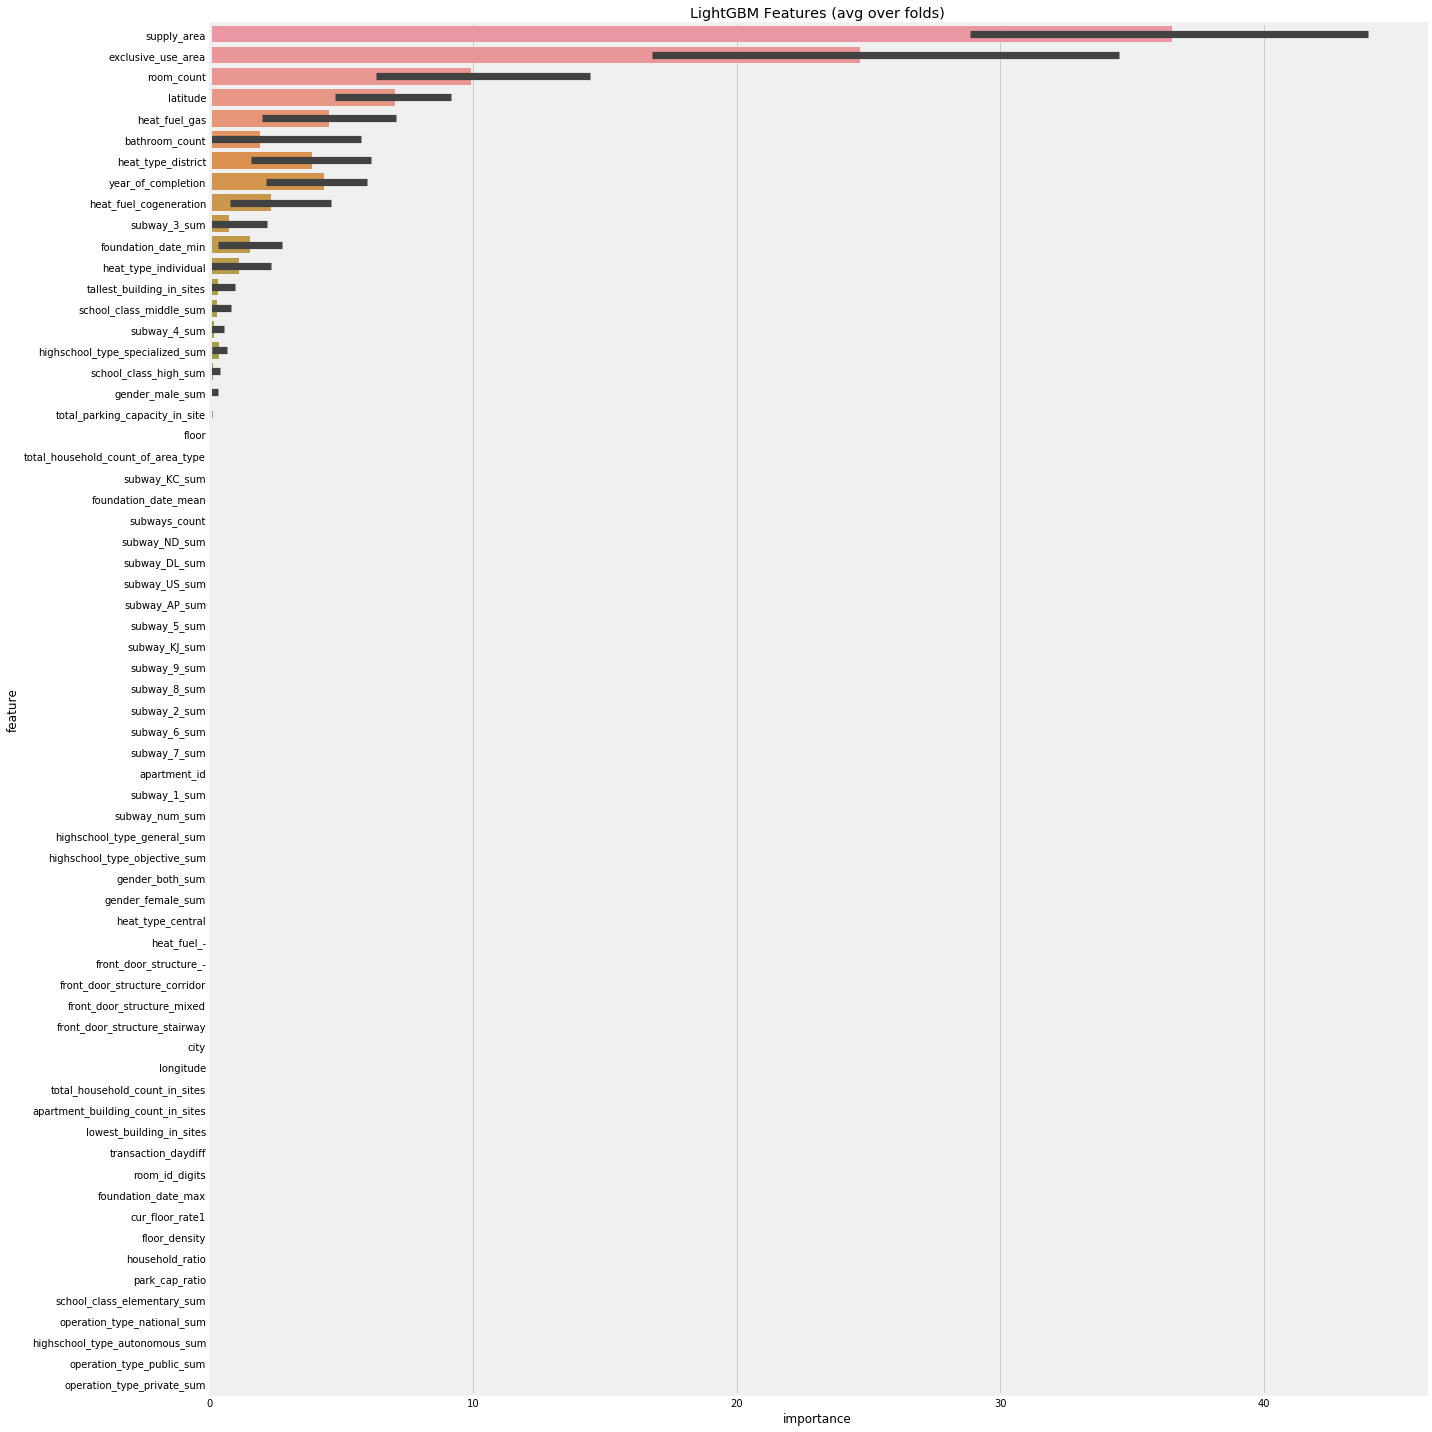

In [87]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(20,20))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('catboost_importances.png')

In [154]:
#train=train.drop(['transaction_real_price'],axis=1)
#test=test.drop(['transaction_real_price'],axis=1)

64

In [155]:
print(len(train.columns))
print(len(test.columns))

64
64


In [304]:
train1=train.copy()
test1=test.copy()
#train1=train1.drop(['transaction_real_price'],axis=1)
#test1=test1.drop(['transaction_real_price'],axis=1)
train1['target']=1
test1['target']=0
train_test = pd.concat([train1, test1], axis =0)

In [305]:
input_var=[x for x in train_test.columns if x not in ['target','key','transaction_real_price']]
X=train_test[input_var]
y = train_test['target']

In [306]:
y.value_counts()

1    1601458
0       3918
Name: target, dtype: int64

In [307]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.001,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_test))

a=1
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X,y)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])

    num_round = 10
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)


fold n°0
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[10]	training's auc: 0.992553	valid_1's auc: 0.992343
fold n°1
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[7]	training's auc: 0.993004	valid_1's auc: 0.991748
fold n°2
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[10]	training's auc: 0.992422	valid_1's auc: 0.994039
fold n°3
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[10]	training's auc: 0.992547	valid_1's auc: 0.991377
fold n°4
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[10]	training's auc: 0.993447	valid_1's auc: 0.990953


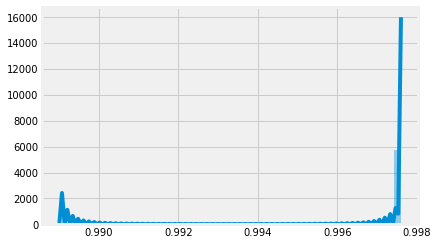

In [308]:
sns.distplot(oof)

In [309]:
train_test['target'].mean()

0.9975594502471695

In [310]:
pd.Series(oof).describe()

count    1.6053760000e+06
mean     9.9755858308e-01
std      2.5766997428e-04
min      9.8901293548e-01
25%      9.9757357432e-01
50%      9.9757682643e-01
75%      9.9758095400e-01
max      9.9759505122e-01
dtype: float64

In [311]:
np.mean(oof<9.9757357432e-01)

0.27802707901451124

In [312]:
a=train_test.loc[(oof<9.97571e-01) & (train_test['target']==1),]

In [313]:
len(a)

167291

In [317]:
a=a.drop(['target'],axis=1)

In [319]:
train=a.copy()

In [267]:
len(train)

1601458

In [184]:
len(train_test)

1605376

In [188]:
train

,city,year_of_completion,exclusive_use_area,floor,latitude,longitude,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,tallest_building_in_sites,lowest_building_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,transaction_daydiff,room_id_digits,park_cap_ratio,cur_floor_rate1,floor_density,household_ratio,subway_num_sum,subway_1_sum,subway_2_sum,subway_3_sum,subway_4_sum,subway_5_sum,subway_6_sum,subway_7_sum,subway_8_sum,subway_9_sum,subway_KJ_sum,subway_US_sum,subway_AP_sum,subway_KC_sum,subway_DL_sum,subway_ND_sum,subways_count,foundation_date_mean,foundation_date_min,foundation_date_max,school_class_elementary_sum,school_class_high_sum,school_class_middle_sum,operation_type_national_sum,operation_type_private_sum,operation_type_public_sum,highschool_type_autonomous_sum,highschool_type_general_sum,highschool_type_objective_sum,highschool_type_specialized_sum,gender_both_sum,gender_female_sum,gender_male_sum,heat_type_central,heat_type_district,heat_type_individual,heat_fuel_-,heat_fuel_cogeneration,heat_fuel_gas,front_door_structure_-,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway,target
0,1,1999,47.4300,6,37.5859650564,127.0002309679,163.0,136,1,8.0,4.0,65.63,46,1.0,1.0,4748,5,1.1985294118,1.5000000000,5.0000000000,0.3382352941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,1,0,1,0,0,1
1,1,1999,44.3700,8,37.5859650564,127.0002309679,163.0,136,1,8.0,4.0,61.39,10,2.0,1.0,4748,5,1.1985294118,2.0000000000,5.0000000000,0.0735294118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,1,0,1,0,0,1
2,1,1992,54.7000,8,37.5805114126,127.0140155573,902.0,585,5,14.0,9.0,72.36,201,2.0,1.0,4748,4,1.5418803419,0.8888888889,1.2000000000,0.3435897436,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1951.0000000000,1916.0,1971.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0,0,1,0,0,1,0,1,0,0,1
3,1,1993,64.6600,11,37.5803242494,127.0117875296,902.0,919,7,15.0,11.0,87.30,284,2.0,1.0,4748,4,0.9815016322,1.0000000000,0.7142857143,0.3090315560,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1951.0000000000,1916.0,1971.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0,0,1,0,0,1,0,1,0,0,1
4,1,1993,106.6200,7,37.5803242494,127.0117875296,902.0,919,7,15.0,11.0,127.74,112,4.0,2.0,4748,4,0.9815016322,0.6363636364,0.7142857143,0.1218715996,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1951.0000000000,1916.0,1971.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0,0,1,0,0,1,0,0,0,1,1
5,1,2000,84.9200,9,37.5753808827,126.9608044143,1365.0,964,12,23.0,10.0,109.88,454,3.0,2.0,4748,4,1.4159751037,0.9000000000,1.1666666667,0.4709543568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957.0000000000,1957.0,1957.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,1,0,0,0,1,1
6,1,2000,60.0000,13,37.5753808827,126.9608044143,1365.0,964,12,23.0,10.0,84.33,207,3.0,1.0,4748,4,1.4159751037,1.3000000000,1.1666666667,0.2147302905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1957.0000000000,1957.0,1957.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,1,0,1,0,0,1
7,1,2005,84.7600,10,37.5592002897,127.0195030112,652.0,461,9,23.0,6.0,104.30,82,3.0,2.0,4748,5,1.4143167028,1.6666666667,2.0000000000,0.1778741866,5.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1953.0625000000,1895.0,2007.0,6.0,5.0,5.0,0.0,7.0,9.0,1.0,1.0,0.0,3.0,8.0,2.0,6.0,0,0,1,0,0,1,0,0,0,1,1
8,1,1999,84.8800,18,37.5550600267,127.0144951688,2091.0,2282,19,20.0,8.0,107.65,576,3.0,2.0,4748,4,0.9163014899,2.2500000000,0.6842105263,0.2524101665,5.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1953.0625000000,1895.0,2007.0,6.0,5.0

In [108]:
import lightgbm as lgb
param = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.5,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}


trn_data = lgb.Dataset(X, label=y)#, categorical_feature=categorical_feats)
#val_data = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])#, categorical_feature=categorical_feats)

num_round = 10000
clf = lgb.train(param, trn_data, num_round,verbose_eval=100, early_stopping_rounds = 200)

ValueError: For early stopping, at least one dataset and eval metric is required for evaluation